<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [13]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Unnamed: 0,TICKER,DTYYYYMMDD,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE
0,0,مظنه,20191120,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
1,1,مظنه,20191123,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
2,2,مظنه,20191124,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
3,3,مظنه,20191125,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
4,4,مظنه,20191126,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0


In [0]:
max_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.max).reset_index().sort_values('VOL', ascending=False).head()

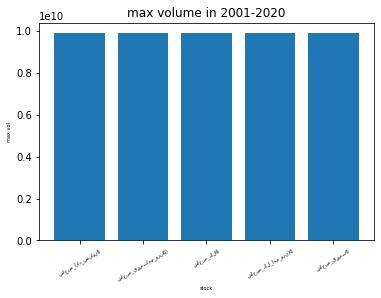

In [48]:
 index = numpy.arange(len(max_vol_per_ticker['TICKER']))
 plt.bar(index, max_vol_per_ticker['VOL'])
 plt.xlabel('stock', fontsize=5)
 plt.ylabel('max vol', fontsize=5)
 plt.xticks(index, max_vol_per_ticker['TICKER'], fontsize=5, rotation=30)
 plt.title('max volume in 2001-2020')
 plt.show()